In [1]:
#### import tensorflow as tf
import os
import cv2
import numpy as np

# Définir le chemin vers le dataset
dataset_path = '/kaggle/input/ucsd-anomaly-detection-dataset/UCSD_Anomaly_Dataset.v1p2'

# Chemins vers les sous-dossiers pour les jeux de données
paths = {
    'UCSDped1_Train': os.path.join(dataset_path, 'UCSDped1', 'Train'),
    'UCSDped1_Test': os.path.join(dataset_path, 'UCSDped1', 'Test'),
    'UCSDped2_Train': os.path.join(dataset_path, 'UCSDped2', 'Train'),
    'UCSDped2_Test': os.path.join(dataset_path, 'UCSDped2', 'Test')
}

In [2]:
# Fonction pour charger les chemins d'images depuis un dossier
def get_image_paths(folder_path):
    image_paths = []
    if not os.path.exists(folder_path):
        print(f"Chemin non trouvé : {folder_path}")
        return image_paths

    for subfolder in sorted(os.listdir(folder_path)):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):  # Vérifiez si c'est un dossier
            for filename in sorted(os.listdir(subfolder_path)):
                img_path = os.path.join(subfolder_path, filename)
                # Vérifie l'extension de fichier pour éviter les fichiers non image
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif','tif')):
                    image_paths.append(img_path)
    return image_paths

# Récupérer tous les chemins d'images pour chaque dossier
train1_paths = get_image_paths(paths['UCSDped1_Train'])
test1_paths = get_image_paths(paths['UCSDped1_Test'])
train2_paths = get_image_paths(paths['UCSDped2_Train'])
test2_paths = get_image_paths(paths['UCSDped2_Test'])


In [3]:
from PIL import Image
import numpy as np

# Définir img_width et img_height si ce n'est pas encore fait
img_width = 128  # Remplacez par la largeur souhaitée
img_height = 128  # Remplacez par la hauteur souhaitée

def load_tif_image(file_path):
    try:
        with Image.open(file_path) as img:
            img = img.convert("L")  # Convertir en niveaux de gris
            img = img.resize((img_width, img_height))  # Redimensionner
            img_array = np.array(img) / 255.0  # Normaliser
            return img_array
    except Exception as e:
        print(f"Erreur lors du chargement de l'image {file_path}: {e}")
        return None

In [4]:
# Fonction pour vérifier si un fichier est dans un dossier qui se termine par 'gt'
def is_gt_folder(image_path):
    # Extraire le dossier parent de l'image
    parent_folder = os.path.basename(os.path.dirname(image_path))
    
    # Vérifier si le nom du dossier parent se termine par 'gt'
    return parent_folder.endswith('gt')

In [5]:
# Chargez les images et filtrez celles qui sont None
train1_images = [load_tif_image(path) for path in train1_paths]
train1_images = [img for img in train1_images if img is not None]  # Filtrer les None

test1_images = [load_tif_image(path) for path in test1_paths if not is_gt_folder(path)]
test1_images = [img for img in test1_images if img is not None]  # Filtrer les None

Erreur lors du chargement de l'image /kaggle/input/ucsd-anomaly-detection-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test017/142.tif: -2


PackBitsDecode: Not enough data for scanline 0.


In [6]:
# Chargez les images et filtrez celles qui sont None
train2_images = [load_tif_image(path) for path in train2_paths]
train2_images = [img for img in train1_images if img is not None]  # Filtrer les None

test2_images = [load_tif_image(path) for path in test2_paths if not is_gt_folder(path)]
test2_images = [img for img in test1_images if img is not None]  # Filtrer les None

In [7]:
# Combinez les ensembles d'images d'entraînement
all_train_images = train1_images + train2_images
#all_train_images = train1_images
# Combinez les ensembles d'images de test
all_test_images = test1_images + test2_images
#all_test_images = test1_images

In [8]:

# Convertir les listes d'images en tableaux NumPy
train_images = np.array(all_train_images)
test_images = np.array(all_test_images)

# Vérifiez les formes finales
print(f"train_images shape: {train_images.shape}")
print(f"test_images shape: {test_images.shape}")

train_images shape: (13600, 128, 128)
test_images shape: (14398, 128, 128)


In [9]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=512, dropout_prob=0.1):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),
        )

        # Calculer la taille de sortie de l'encodeur
        sample_input = torch.randn(1, in_channels, 128, 128)
        output_features = self.encoder(sample_input).view(1, -1).shape[1]
        
        # Couches linéaires pour mu et logvar
        self.fc_mu = nn.Linear(output_features, latent_dim)
        self.fc_logvar = nn.Linear(output_features, latent_dim)

        # Décodeur linéaire
        self.fc_decode = nn.Linear(latent_dim, output_features)

        # Décodeur convolutif
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # Normalisation entre 0 et 1
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 1024, 4, 4)  # Ajustement pour le décodeur
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [10]:
import torch
import torch.nn as nn
from torchvision import transforms  # Assurez-vous d'importer transforms
import numpy as np

transform = transforms.Compose([
     transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [11]:
import torch.nn as nn

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        # Initialisation de He pour les couches convolutives (ReLU)
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  
    elif isinstance(m, nn.BatchNorm2d):
        # Initialisation pour les couches BatchNorm
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        # Initialisation Xavier pour les couches linéaires (surtout si elles sont suivies d'une activation non linéaire)
        torch.nn.init.xavier_normal_(m.weight)  # Xavier pour les couches linéaires
        torch.nn.init.constant_(m.bias, 0)  # Initialisation des biais à 0


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Créer une instance du modèle VAE
vae = VAE().to(device)
# Appliquer la fonction d'initialisation des poids
vae.apply(weights_init)


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.1, inpl

In [13]:
train_images_tensor = torch.tensor(train_images).unsqueeze(1)  # Ajouter un canal pour le noir et blanc


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

# Définition de la classe CustomDataset
class CustomDataset(Dataset):
    def __init__(self, images_tensor, transform=None):
        self.images_tensor = images_tensor
        self.transform = transform

    def __len__(self):
        return len(self.images_tensor)

    def __getitem__(self, idx):
        image = self.images_tensor[idx]  # Obtenir l'image
        if self.transform:
            image = self.transform(image)  # Appliquer les transformations si définies
        return image

In [15]:
# Vérifiez si les dimensions sont correctes
print(train_images_tensor.shape)  # Devrait être [num_images, 1, 128, 128]

# Définir les transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.float())  # Convertir en float, si nécessaire
])

# Créer l'instance de votre dataset
custom_dataset = CustomDataset(train_images_tensor, transform=transform)

# Créer le DataLoader
batch_size = 128  # Ajustez en fonction de votre mémoire disponible
dataloader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4  # Ajustez en fonction de votre système
)




torch.Size([13600, 1, 128, 128])


In [16]:
import torch
from torch.utils.data import DataLoader, random_split

# Définir la taille de votre ensemble de validation (par exemple 20% des données)
val_split = 0.2
dataset_size = len(custom_dataset)
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size

# Diviser le dataset en ensembles d'entraînement et de validation
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Créer les DataLoaders pour l'entraînement et la validation
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,  # Mélanger les données d'entraînement
    num_workers=4  # Ajustez en fonction de votre système
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,  # Pas besoin de mélanger les données de validation
    num_workers=4  # Ajustez en fonction de votre système
)


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Époque [1/100], Perte moyenne d'entraînement : 1055.8145
Époque [1/100], Perte moyenne de validation : 198.6104
Époque [2/100], Perte moyenne d'entraînement : 327.0503
Époque [2/100], Perte moyenne de validation : 108.9359
Époque [3/100], Perte moyenne d'entraînement : 202.1842
Époque [3/100], Perte moyenne de validation : 106.6768
Époque [4/100], Perte moyenne d'entraînement : 167.3754
Époque [4/100], Perte moyenne de validation : 113.4675
Époque [5/100], Perte moyenne d'entraînement : 143.5606
Époque [5/100], Perte moyenne de validation : 92.3783
Époque [6/100], Perte moyenne d'entraînement : 125.8917
Époque [6/100], Perte moyenne de validation : 79.0142
Époque [7/100], Perte moyenne d'entraînement : 133.0178
Époque [7/100], Perte moyenne de validation : 75.0902
Époque [8/100], Perte moyenne d'entraînement : 105.3081
Époque [8/100], Perte moyenne de validation : 69.8145
Époque [9/100], Perte moyenne d'entraînement : 97.5532
Époque [9/100], Perte moyenne de validation : 66.0525
Époque

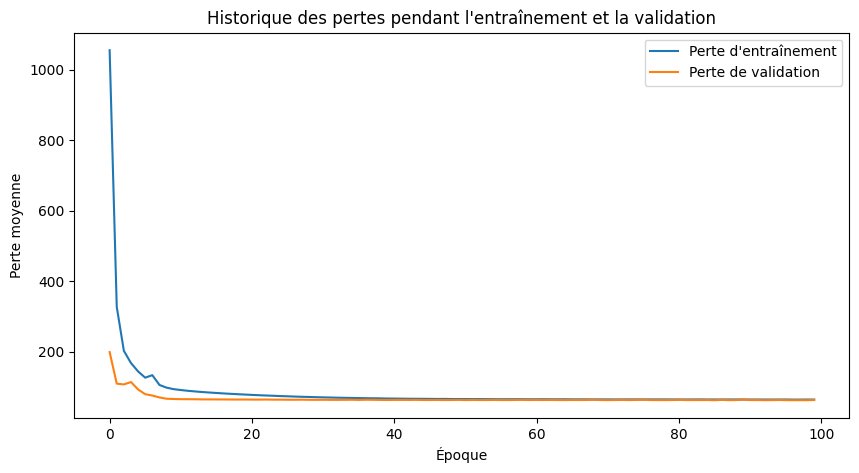

Entraînement terminé.


In [17]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Définir les hyperparamètres
num_epochs = 100
#learning_rate = 0.001
learning_rate = 0.0005
weight_decay = 1e-5 # Choisir la régularisation L2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimiseur
#optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
optimizer = AdamW(vae.parameters(), lr=learning_rate,weight_decay =weight_decay )
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Liste pour enregistrer l'historique de la perte
loss_history = []
val_loss_history = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0

    # Entraînement sur train_dataloader
    for batch in train_dataloader:
        images = batch  # Chargement des images dans le batch
        images = images.to(device)  # Assurez-vous que les images et le modèle sont sur le même appareil
        
        # Forward pass : calcul de la reconstruction et des paramètres latents
        reconstructed, mu, log_var = vae(images)
        reconstructed_resized = F.interpolate(reconstructed, size=images.shape[2:], mode='bilinear', align_corners=False)

        # Calcul de la perte de reconstruction
        reconstruction_loss = F.mse_loss(reconstructed_resized, images, reduction="sum")

        # Calcul de la KL divergence
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        beta = 3  # Ajustez selon les besoins, régularisation de la KL divergence pour éviter que le modèle ne se focalise trop sur des détails spécifiques des données d’entraînement.

        # Perte totale
        loss = reconstruction_loss + beta * kl_divergence
        total_loss += loss.item()

        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Afficher la perte moyenne par image pour l'époque
    avg_loss = total_loss / len(train_dataloader.dataset)
    loss_history.append(avg_loss)  # Ajouter la perte moyenne à l'historique
    print(f"Époque [{epoch + 1}/{num_epochs}], Perte moyenne d'entraînement : {avg_loss:.4f}")
    
    # Validation
    vae.eval()  # Passer le modèle en mode évaluation
    total_val_loss = 0

    with torch.no_grad():  # Désactiver le calcul des gradients pendant la validation
        for batch in val_dataloader:
            images = batch  # Chargement des images dans le batch
            images = images.to(device)  # Assurez-vous que les images et le modèle sont sur le même appareil

            # Forward pass : calcul de la reconstruction et des paramètres latents
            reconstructed, mu, log_var = vae(images)
            reconstructed_resized = F.interpolate(reconstructed, size=images.shape[2:], mode='bilinear', align_corners=False)

            # Calcul de la perte de reconstruction
            reconstruction_loss = F.mse_loss(reconstructed_resized, images, reduction="sum")

            # Calcul de la KL divergence
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            beta = 3 # Ajustez selon les besoins

            # Perte totale
            val_loss = reconstruction_loss + beta * kl_divergence
            total_val_loss += val_loss.item()

    # Afficher la perte moyenne de validation
    avg_val_loss = total_val_loss / len(val_dataloader.dataset)
    val_loss_history.append(avg_val_loss)
    print(f"Époque [{epoch + 1}/{num_epochs}], Perte moyenne de validation : {avg_val_loss:.4f}")

# Affichage de l'historique de la perte
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Perte d\'entraînement')
plt.plot(val_loss_history, label='Perte de validation')
plt.title('Historique des pertes pendant l\'entraînement et la validation')
plt.xlabel('Époque')
plt.ylabel('Perte moyenne')
plt.legend()
plt.show()

print("Entraînement terminé.")


In [18]:
import joblib
import os
# Assurez-vous que le répertoire outputs existe
if not os.path.exists('Outputs'):
    os.makedirs('Outputs')
    # Enregistrer le modèle dans le répertoire outputs
joblib.dump(vae, 'Outputs/VAE_lastversionarch2.pkl')

['Outputs/VAE_lastversionarch2.pkl']